# Import Data

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  5 15:36:05 2018

@author: amariller
"""


%reset -f

import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster import hierarchy
from scipy import stats

import plotly.plotly as py
import plotly.graph_objs as go

from IPython.display import display

#import sompy

data_path = "..\\data\\raw\\"
headers = ["Product","Client"]


# #Product and promo files
# df_product = pd.read_csv(data_path + "data_prod_bnd_ita.csv", sep = ";", encoding = 'iso8859_2')
# # df_promo = pd.read_csv(data_path + "data_promo_bnd_ita2.csv", sep = ";", encoding = 'iso8859_2')

# #History files for P2C1 and P2C4
# df_histo_p2c1 = pd.read_csv(data_path + "data_histo_bnd_ita_p2c1.csv", sep = ";", encoding = 'iso8859_2', header = 0)
# df_histo_p2c4 = pd.read_csv(data_path + "data_histo_bnd_ita_p2c4.csv", sep = ";", encoding = 'iso8859_2', header = 0)


# #Client files
# df_client = pd.read_csv(data_path + "data_client_bnd_ita.csv", sep = ";", encoding = 'iso8859_2', header = 0)

## Daily Files
Load very large file

In [2]:
p2c4File = "histo_BONDUELLE_27032018_p2c4_jour.txt"
headers = ["Product","Client"]
start_date = '01-04-2016' #mm/dd/yyyy
end_date = "201804"
df_histo_p2c4_jour = pd.read_csv(data_path + p2c4File, sep = ";", encoding = 'iso8859_2', header = None)\
                        .drop([1,3,4,5,6],axis=1).fillna(0)
df_histo_p2c4_jour.head()

sales_df = df_histo_p2c4_jour;

In [4]:
from datetime import datetime

columns = headers.copy()
N,M = sales_df.shape


nb_days = len(sales_df.columns) - len(headers)

date_range = pd.date_range(start = start_date,periods = nb_days, freq='1d').strftime("%d/%m/%Y")
# days = pd.to_datetime(np.arange(0,M-2),unit='D').strftime("%d/%m/%Y")
columns.extend(date_range)
sales_df.columns = columns
print(sales_df.shape)
sales_df.head()

(9125, 753)


,Product,Client,04/01/2016,05/01/2016,06/01/2016,07/01/2016,08/01/2016,09/01/2016,10/01/2016,11/01/2016,...,14/01/2018,15/01/2018,16/01/2018,17/01/2018,18/01/2018,19/01/2018,20/01/2018,21/01/2018,22/01/2018,23/01/2018
0,GBA001AUC180FS,68L041,0.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GBA001AUC180FS,68L042,0.0,1.0,2.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GBA001AUC180FS,0,0.0,3.0,2.0,3.0,0.0,5.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GBA001BND060FS,68C011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GBA001BND060FS,68C120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate quantities by product group

In [9]:
HistPerProduct_p2c4_jour = sales_df.drop(['Client'],axis=1).groupby(["Product"]).sum().fillna(0)
#remove tailing zeros

#HistPerProduct_p2c4_jour = df_product.iloc[:,:-304]


interim_path = "..\\data\\interim\\"
file_name = "HistPerProduct_p2c4_jour.csv"
HistPerProduct_p2c4_jour.to_csv(interim_path+file_name, sep=';', encoding='utf-8')



# Display Data

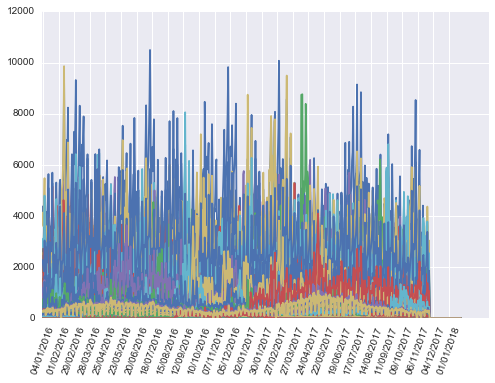

In [8]:
list_it = list(range(len(HistPerProduct_p2c4_jour.columns)))[1:]

tick_frequency = 4 * 7 

for index, row in HistPerProduct_p2c4_jour.iterrows():
    plt.plot(list(row))

plt.xticks(list_it[::tick_frequency], list(HistPerProduct_p2c4_jour.columns)[::tick_frequency], rotation = 70)
plt.show()

# Transform Data

In [2]:
def get_list_client_lvl1(str_ClientPromo, df_AllClient):
    
    list_client = []
    
    for index, row in df_client.iterrows():
       
        if (row['Key_lvl1'] == str_ClientPromo 
        or row['Key_lvl2'] == str_ClientPromo 
        or row['Key_lvl3'] == str_ClientPromo 
        or row['Key_lvl4'] == str_ClientPromo 
        or row['Key_lvl5'] == str_ClientPromo 
        or row['Key_lvl6'] == str_ClientPromo ):                     
            list_client.append(row['Key_lvl1'])
            
    return list_client



def get_list_client_lvl4(str_ClientPromo, df_AllClient):
    
    list_client = []
    
    for index, row in df_client.iterrows():
       
        if (row['Key_lvl1'] == str_ClientPromo 
            or row['Key_lvl2'] == str_ClientPromo 
            or row['Key_lvl3'] == str_ClientPromo 
            or row['Key_lvl4'] == str_ClientPromo 
            or row['Key_lvl5'] == str_ClientPromo 
            or row['Key_lvl6'] == str_ClientPromo ):                     
           
            list_client.append(row['Key_lvl4'])
            
    return list(set(list_client))

test_promo_cli = '1'  

#Get clients of level 1 and 4
list_lvl1_cli = get_list_client_lvl1(test_promo_cli, df_client)
list_lvl4_cli = get_list_client_lvl4(test_promo_cli, df_client)


#Get unique products of level 1 clients
df_HistoCli_p2c1 = df_histo_p2c1.loc[df_histo_p2c1['Client'].isin(list_lvl1_cli)]
list_UnqProd = list(set(df_HistoCli_p2c1['Product']))

#Create empty DF for unique products
df_HistPerProduct_p2c1 = pd.DataFrame(columns = df_HistoCli_p2c1.columns, index = list_UnqProd)




#Actually a group by/SUM of unqiue products
for str_prod in list_UnqProd:
    df_temp = df_HistoCli_p2c1[df_HistoCli_p2c1['Product'] == str_prod]
    df_test = df_temp.sum(axis = 0, skipna = True) 
    df_HistPerProduct_p2c1.loc[str_prod] = df_test
    

df_HistPerProduct_p2c1.drop(['Product', 'Client'], axis = 1, inplace = True)     
df_HistPerProduct_p2c1 = df_HistPerProduct_p2c1[df_HistPerProduct_p2c1.sum(axis = 1) != 0]
df_HistPerProduct_p2c1 = df_HistPerProduct_p2c1[~np.isnan(df_HistPerProduct_p2c1.sum(axis = 1))]



df_HistoCli_p2c4 = df_histo_p2c4.loc[df_histo_p2c4['Client'].isin(list_lvl4_cli)] 
list_UnqProd = list(set(df_HistoCli_p2c4['Product']))
df_HistPerProduct_p2c4 = pd.DataFrame(columns = df_HistoCli_p2c4.columns, index = list_UnqProd)


for str_prod in list_UnqProd:
    df_temp = df_HistoCli_p2c4[df_HistoCli_p2c4['Product'] == str_prod]
    df_test = df_temp.sum(axis = 0, skipna = True) 
    df_HistPerProduct_p2c4.loc[str_prod] = df_test
    
    
df_HistPerProduct_p2c4.drop(['Product', 'Client'], axis = 1, inplace = True) 
df_HistPerProduct_p2c4 = df_HistPerProduct_p2c4[df_HistPerProduct_p2c4.sum(axis = 1) != 0]
df_HistPerProduct_p2c4 = df_HistPerProduct_p2c4[~np.isnan(df_HistPerProduct_p2c4.sum(axis = 1))]


# Save Data

In [14]:
interim_path = "..\\data\\interim\\"

file_name = "HistPerProduct_p2c1.csv"
#df_HistPerProduct_p2c1.to_csv(interim_path+file_name, sep=';', encoding='utf-8')

# Load Saved Data

In [15]:
file_name = "HistPerProduct_p2c1.csv"
df_HistPerProduct_p2c1 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)

df_HistPerProduct_p2c1.head()

,Unnamed: 0,201601,201602,201603,201604,201605,201606,201607,201608,201609,...,201743,201744,201745,201746,201747,201748,201749,201750,201751,201752
0,GLA001VLR125FS,2173.0,2571.0,2697.0,2714.0,2795.0,2915.0,2931.0,3069.0,2965.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GWC012NEU500FS,125.0,111.0,97.0,76.0,81.0,80.0,46.0,48.0,54.0,...,440.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GLV001NTA100FS,3254.0,2450.0,2264.0,3334.0,3149.0,3174.0,3200.0,3375.0,3782.0,...,4179.0,4035.0,3031.0,3506.0,3696.0,3800.0,2962.0,3048.0,2896.0,3204.0
3,GLV001BND060SS,1452.0,1592.0,1444.0,1435.0,1424.0,1409.0,1549.0,1507.0,1405.0,...,1324.0,1554.0,1690.0,1340.0,1384.0,1256.0,1201.0,1132.0,1328.0,1333.0
4,GWP007PAM080FP,1228.0,1272.0,1219.0,1256.0,1261.0,1246.0,1329.0,1310.0,1301.0,...,1231.0,1163.0,1220.0,1186.0,1191.0,1149.0,1064.0,1204.0,1173.0,835.0
